In [205]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import tensorflow as tf

In [206]:
def create_sequences(data, n_steps):
    X = []
    y = []
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps), 0])
        y.append(data[i + n_steps, 0])
    return np.array(X), np.array(y)

In [207]:
def plot(df, field, label):
  plt.figure(figsize=(6, 4))
  plt.plot(df['date'], df[field], linestyle='-',label='Wheat Prices')
  plt.title(label)
  plt.xlabel('Time')
  plt.ylabel('Price')
  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()
  print("\n\n")

In [208]:
df = pd.read_csv("modal_uttar_pradesh.csv")
df['date'] = pd.to_datetime(df['date'])

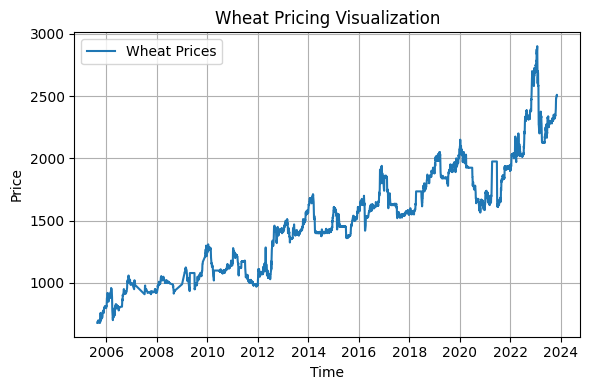

In [209]:
plot(df, "modal_price", "Wheat Pricing Visualization")

In [210]:
df.set_index('date', inplace=True)

In [211]:
y = df['modal_price'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
y_normalized = scaler.fit_transform(y)

In [212]:
steps = 100

In [213]:
#create sequences for training and testing
X, y = create_sequences(y_normalized, steps)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [214]:
split_percentage = 0.8
split_index = int(split_percentage * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [215]:
# setup test and train for date time plotting
train = pd.DataFrame(df.iloc[:split_index])
test = pd.DataFrame(df.iloc[split_index:])

In [40]:
len(y_test)

1329

In [216]:
# create LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


In [217]:
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# make test set predictions
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))

# invert scaling for the actual test set for eval
y_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# MSE evaluation
mse = mean_squared_error(y_actual, y_pred)
print(f'Mean Squared Error: {mse}')


Epoch 1/20
164/164 [==============================] - 29s 169ms/step - loss: 0.0056
Epoch 2/20
164/164 [==============================] - 27s 163ms/step - loss: 1.1189e-04
Epoch 3/20
164/164 [==============================] - 27s 164ms/step - loss: 1.0315e-04
Epoch 4/20
164/164 [==============================] - 27s 163ms/step - loss: 9.7778e-05
Epoch 5/20
164/164 [==============================] - 26s 161ms/step - loss: 9.2446e-05
Epoch 6/20
164/164 [==============================] - 26s 162ms/step - loss: 8.9831e-05
Epoch 7/20
164/164 [==============================] - 26s 157ms/step - loss: 9.0148e-05
Epoch 8/20
164/164 [==============================] - 25s 152ms/step - loss: 8.0526e-05
Epoch 9/20
164/164 [==============================] - 26s 161ms/step - loss: 7.7035e-05
Epoch 10/20
164/164 [==============================] - 27s 166ms/step - loss: 7.4936e-05
Epoch 11/20
164/164 [==============================] - 27s 163ms/step - loss: 7.4166e-05
Epoch 12/20
164/164 [=============

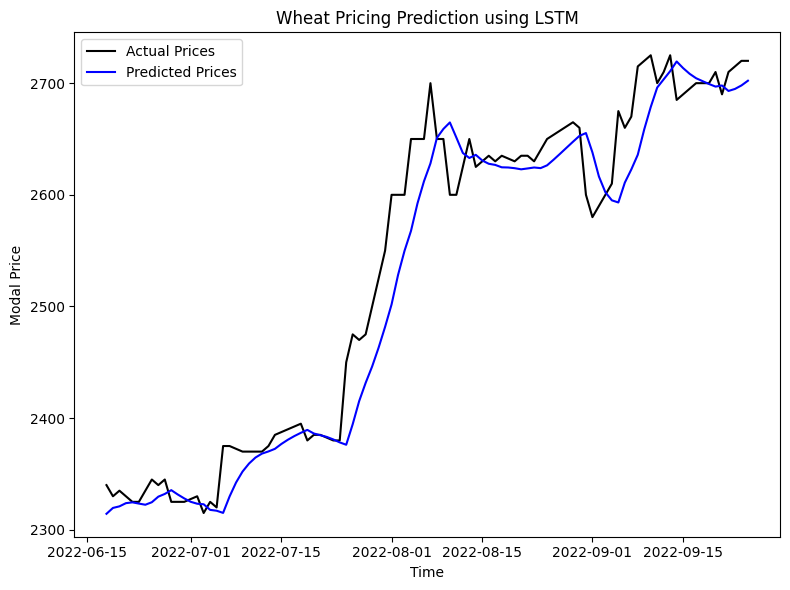

In [192]:
interval = (900,1000)

plt.figure(figsize=(8, 6))
plt.plot(test[interval[0]:interval[1]].index,y_actual[interval[0]:interval[1]], label='Actual Prices', color='black')
plt.plot(test[interval[0]:interval[1]].index,y_pred[interval[0]:interval[1]], label='Predicted Prices', color='blue')
plt.title('Wheat Pricing Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Modal Price')
plt.tight_layout()
plt.legend()
plt.show()

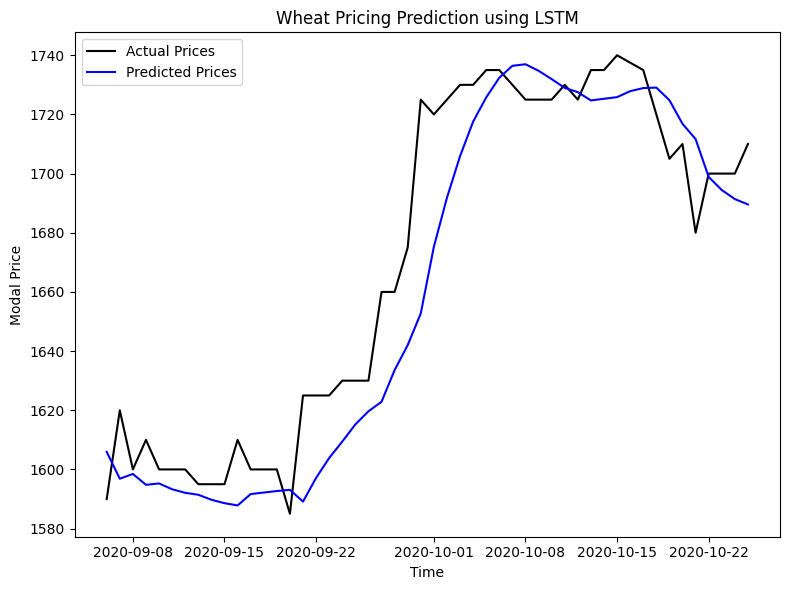

In [193]:
interval = (250,300)

plt.figure(figsize=(8, 6))
plt.plot(test[interval[0]:interval[1]].index,y_actual[interval[0]:interval[1]], label='Actual Prices', color='black')
plt.plot(test[interval[0]:interval[1]].index,y_pred[interval[0]:interval[1]], label='Predicted Prices', color='blue')
plt.title('Wheat Pricing Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Modal Price')
plt.tight_layout()
plt.legend()
plt.show()

3/3 [==============================] - 0s 35ms/step


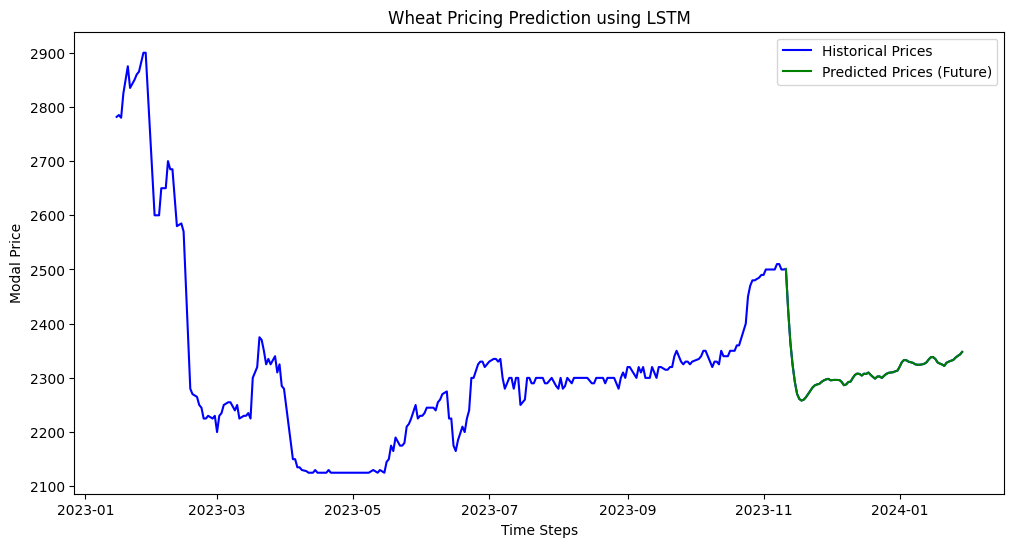

In [204]:
n_future_steps = 80 # how far to predict

X_future = []
last_sequence = y_normalized[-steps:]

for _ in range(n_future_steps):
    X_future.append(last_sequence[-steps:])
    last_sequence = np.roll(last_sequence, -1)  # shift sequence

X_future = np.array(X_future)


X_future = X_future.reshape((X_future.shape[0], steps, 1))
y_future_scaled = model.predict(X_future)
y_future = scaler.inverse_transform(y_future_scaled.reshape(-1, 1))

# generate future timestamps
future_timestamps = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=n_future_steps, freq='D')


plt.figure(figsize=(12, 6))

#concatenate for plotting future
concatenated_date = np.concatenate((df.iloc[-300:].index, future_timestamps), axis = None)
concatenated_price = np.concatenate((df.iloc[-300:]['modal_price'], y_future), axis=None)
plt.plot(concatenated_date, concatenated_price, label='Historical Prices', color='blue')


#plot future in different color
plt.plot(future_timestamps, y_future, label='Predicted Prices (Future)', color='green')

plt.title('Wheat Pricing Prediction using LSTM')
plt.xlabel('Time Steps')
plt.ylabel('Modal Price')
plt.legend()
plt.show()


In [221]:
model.summary()
model.save("/content/model_save")


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 50)                10400     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [223]:
import shutil
folder_path = '/content/model_save'
zip_file_path = '/content/model_save'
shutil.make_archive(zip_file_path, 'zip', folder_path)

'/content/model_save.zip'